In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from utils.path import WildcardPath
import os
from utils.enums import AlignerEnum, FeatureEnum as FE, FeatureDirectionEnum as FDE, FeatureTypeEnum as FTE
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import alignment.ensemble
import alignment.dataset
import utils.plots
from features.labels import LabelCandidateExtractor

In [2]:
DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
RESULT_DIR = WildcardPath("/hits/fast/cme/bodynems/MSA_difficulty/results")

BENCHMARKS = ["balibase3/RV11", "balibase3/RV12"]
# BENCHMARKS = ["treebase_small", "treebase_large"]

INPUT_DIR = DATA_DIR / "input" / "{benchmark}"
OUTPUT_DIR = DATA_DIR / "output" / "{benchmark}"

unaligned_DIR = OUTPUT_DIR / "{dataset}"

FEAT_FILE_PATH = unaligned_DIR / "{file_name}"
TOOL_DIR = unaligned_DIR / "{tool}"

TOOLS = [aligner for aligner in AlignerEnum]
DATASETS = OUTPUT_DIR.format(benchmark=BENCHMARKS[0]).listdir(dirs_only=True)

In [3]:
aligned_features_dfs = []
unaligned_features_dfs = []
confusion_features_dfs = []
# reference_features_dfs = []
for benchmark in BENCHMARKS:
    aligned_features = pd.read_parquet(
        OUTPUT_DIR.format(benchmark=benchmark) / "aligned_features.parquet"
    )
    unaligned_features = pd.read_parquet(
        OUTPUT_DIR.format(benchmark=benchmark) / "unaligned_features.parquet"
    )
    # confusion_features = pd.read_parquet(
    #     OUTPUT_DIR.format(benchmark=benchmark) / "confusion.parquet"
    # )

    aligned_features["benchmark"] = benchmark
    aligned_features_dfs.append(aligned_features)

    unaligned_features["benchmark"] = benchmark
    unaligned_features_dfs.append(unaligned_features)

    # confusion_features["benchmark"] = benchmark
    # confusion_features_dfs.append(confusion_features)

aligned_features = pd.concat(aligned_features_dfs, axis=0, ignore_index=True)
unaligned_features = pd.concat(unaligned_features_dfs, axis=0, ignore_index=True)
# confusion_features = pd.concat(confusion_features_dfs, axis=0, ignore_index=True)
aligned_features = pd.merge(
    aligned_features,
    unaligned_features[["dataset", "data_type", "n_sequences", "max_sequence_length"]],
    how="outer",
    on=["dataset"],
)

In [4]:
print(unaligned_features.shape)
print(aligned_features.shape)
# print(confusion_features.shape)

(162, 87)
(1134, 113)


In [ ]:
plot_df = aligned_features[
    (aligned_features.tool == "all") & (aligned_features.benchmark.str.contains("RV11"))
]
plot_df[
    [
        "mean_" + FE.SSP_DIST,
        "mean_" + FE.HOMOLOGY_SEQ_DIST,
        "mean_" + FE.HOMOLOGY_POS_DIST,
    ]
].corr()

,mean_symmetrized_sp_dist,mean_homology_seq_dist,mean_homology_pos_dist
mean_symmetrized_sp_dist,1.000000,0.941655,0.989064
mean_homology_seq_dist,0.941655,1.000000,0.904222
mean_homology_pos_dist,0.989064,0.904222,1.000000


In [116]:
confusion_features[confusion_features.tool == "all"]

,min_confusion_entropy,max_confusion_entropy,mean_confusion_entropy,median_confusion_entropy,std_confusion_entropy,min_confusion_set,max_confusion_set,mean_confusion_set,median_confusion_set,std_confusion_set,tool,dataset,benchmark
6,0.000000,0.007508,0.000189,0.000000,0.000631,0.00000,0.074405,0.002962,0.000000,0.008867,all,277_0.phy,treebase_testing_small
13,0.000000,0.003575,0.000121,0.000000,0.000408,0.00000,0.041667,0.001205,0.000000,0.004230,all,16569_0.phy,treebase_testing_small
20,0.000000,0.002425,0.000042,0.000000,0.000232,0.00000,0.020833,0.000362,0.000000,0.001998,all,18113_36.phy,treebase_testing_small
27,0.000000,0.011018,0.000694,0.000212,0.001255,0.00000,0.220990,0.010636,0.002912,0.019536,all,13212_0.phy,treebase_testing_small
34,0.000000,0.009105,0.000510,0.000137,0.000948,0.00000,0.143229,0.007082,0.001562,0.013015,all,18638_6.phy,treebase_testing_small
41,0.000000,0.011334,0.001076,0.000200,0.001830,0.00000,0.220930,0.015373,0.002422,0.027906,all,14916_0.phy,treebase_testing_small
48,0.000000,0.011406,0.000398,0.000069,0.001005,0.00000,0.185000,0.003915,0.000833,0.010657,all,16190_3.phy,treebase_testing_small
55,0.000319,0.011717,0.004367,0.004173,0.003008,0.00651,0.239583,0.073791,0.067708,0.054895,all,22408_3.phy,treebase_testing_small
62,0.000000,0.004870,0.000081,0.000000,0.000363,0.00000,0.055780,0.000928,0.000000,0.004115,all,10349_2.phy,treebase_testing_small
69,0.000000,0.002013,0.000002,0.000000,0.000056,0.00000,0.020579,0.000021,0.000000,0.000493,all,16659_7.phy,treebase_testing_small


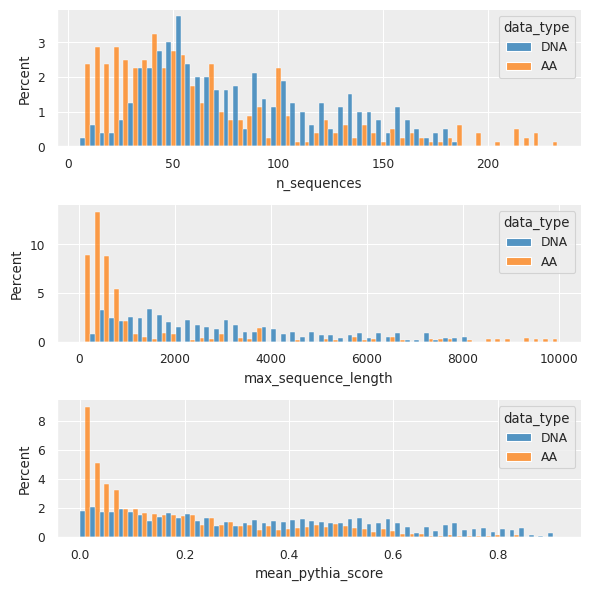

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sn.histplot(
    unaligned_features,
    bins=50,
    x="n_sequences",
    hue="data_type",
    multiple="dodge",
    stat="percent",
    ax=axes[0],
)
sn.histplot(
    unaligned_features,
    bins=50,
    x="max_sequence_length",
    hue="data_type",
    multiple="dodge",
    stat="percent",
    ax=axes[1],
)
sn.histplot(
    aligned_features[aligned_features.tool != "all"],
    bins=50,
    x="mean_" + FE.PYTHIA_SCORE,
    hue="data_type",
    multiple="dodge",
    stat="percent",
    ax=axes[2],
)
fig.tight_layout()

In [7]:
# Compute the share of nan values in gap_delta_dist
aligned_features.groupby("data_type").apply(
    lambda df: df.isna().mean(axis=0), include_groups=False
).mean_gap_delta_dist

data_type
AA     0.052274
DNA    0.026786
Name: mean_gap_delta_dist, dtype: float64

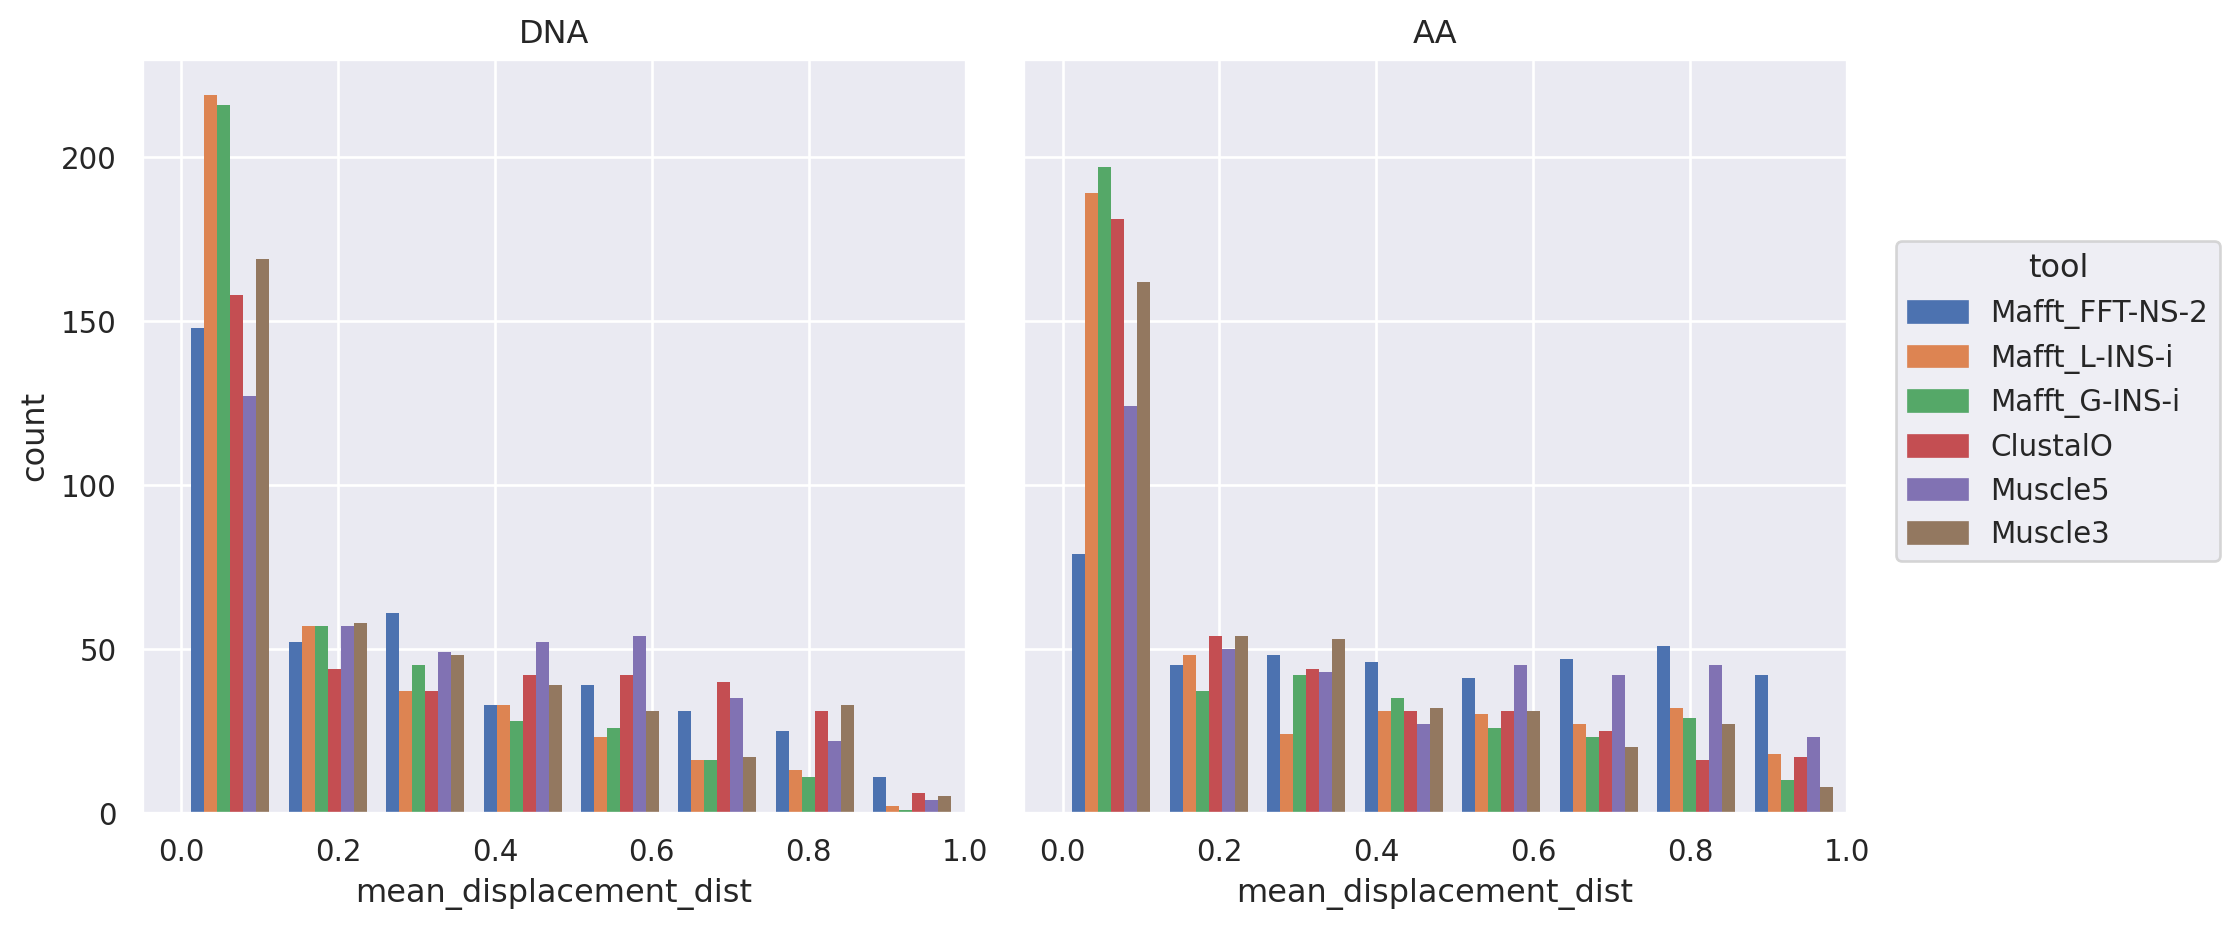

In [12]:
# Compare DNA and AA in terms of distances
p = utils.plots.hist_facet_plot(
    aligned_features[aligned_features.tool != "all"],
    feature="mean_" + FE.DISPLACEMENT_DIST,
    color="tool",
    facet="data_type",
    x_lim=(-0.05, 1),
)
p

<Axes: xlabel='max_sequence_length', ylabel='std_homology_pos_dist'>

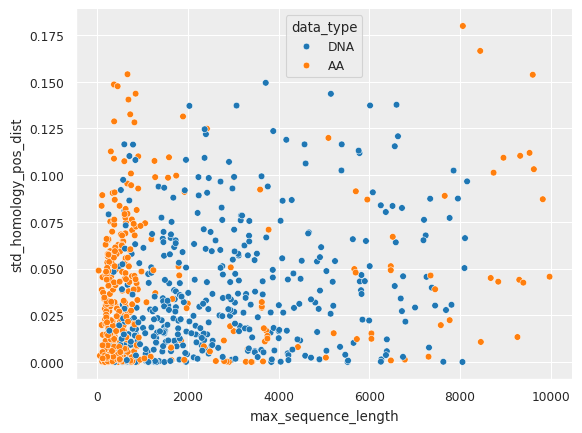

In [ ]:
sn.scatterplot(
    aligned_features[aligned_features.tool == "all"],
    x="max_sequence_length",
    y="std_" + FE.HOMOLOGY_POS_DIST,
    hue="data_type",
)

<Axes: >

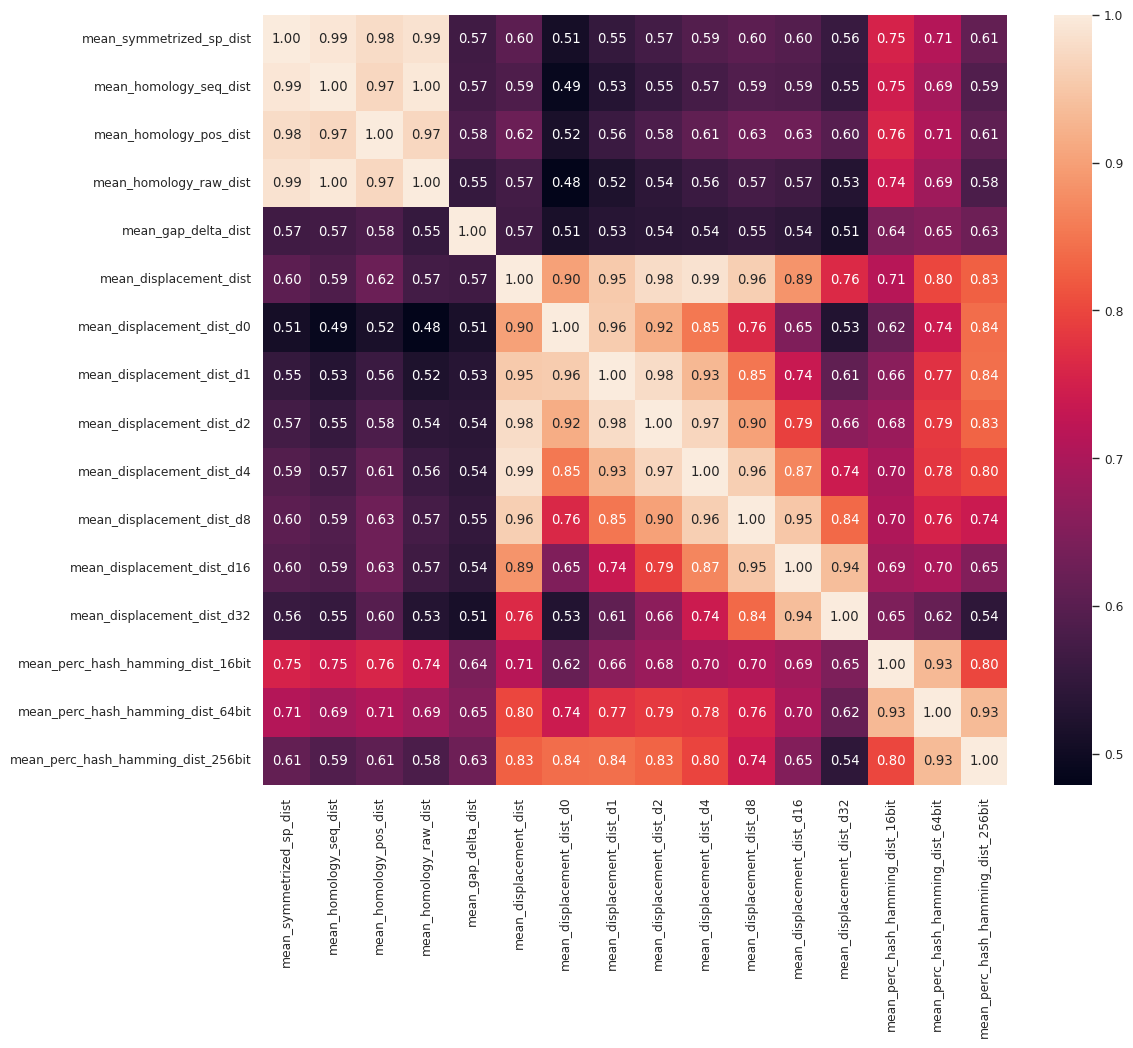

In [13]:
from features.pairwise import _CUSTOM_METRICS

names = ["mean_" + metric.name for metric in _CUSTOM_METRICS]
plot_df = FE.extract_from_df(
    aligned_features, type_enum=FTE.DISTANCE, statistic_filter="mean_"
)
plot_df = plot_df[names]
fig = plt.figure(figsize=(12, 10))
sn.heatmap(plot_df.corr(), annot=True, fmt=".2f")

Index(['tool', 'dataset', 'benchmark', 'data_type'], dtype='object')


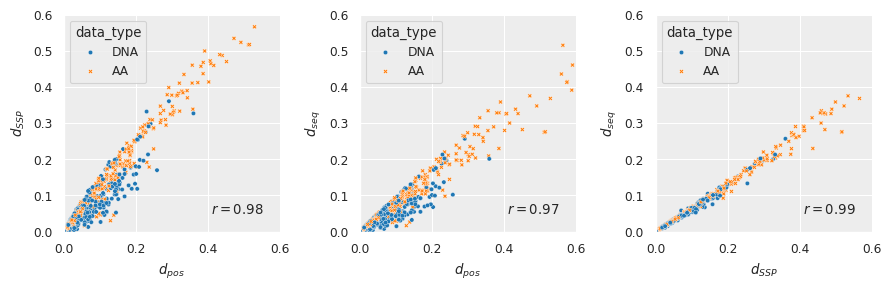

In [14]:
# Compare d_SSP, d_seq, and d_pos

%autoreload 2
from features.pairwise import _CUSTOM_METRICS


names = ["mean_" + metric.name for metric in _CUSTOM_METRICS]
print(aligned_features.select_dtypes("object").columns)
plot_df = FE.extract_from_df(
    aligned_features, type_enum=FTE.DISTANCE, statistic_filter="mean_"
)
plot_df = plot_df.loc[plot_df.tool == "all"]

pairs = [
    (FE.HOMOLOGY_POS_DIST, FE.SSP_DIST),
    (FE.HOMOLOGY_POS_DIST, FE.HOMOLOGY_SEQ_DIST),
    (FE.SSP_DIST, FE.HOMOLOGY_SEQ_DIST),
]
fig, axes = plt.subplots(1, len(pairs), figsize=(9, 3))
for i, (feat_x, feat_y) in enumerate(pairs):
    name_x = "mean_" + feat_x
    name_y = "mean_" + feat_y
    corr_coef = round(plot_df[name_x].corr(plot_df[name_y]), 2)
    sn.scatterplot(
        x=plot_df[name_x],
        y=plot_df[name_y],
        hue=plot_df["data_type"],
        style=plot_df["data_type"],
        alpha=1,
        s=10,
        ax=axes[i],
    )
    sn.move_legend(axes[i], "upper left")
    axes[i].set_xlim(0,0.6)
    axes[i].set_ylim(0,0.6)
    axes[i].set_xlabel(feat_x.pretty)
    axes[i].set_ylabel(feat_y.pretty)
    axes[i].text(x=0.41, y=0.05, s=r"$r = " + str(corr_coef) + "$")
fig.set_layout_engine("tight")

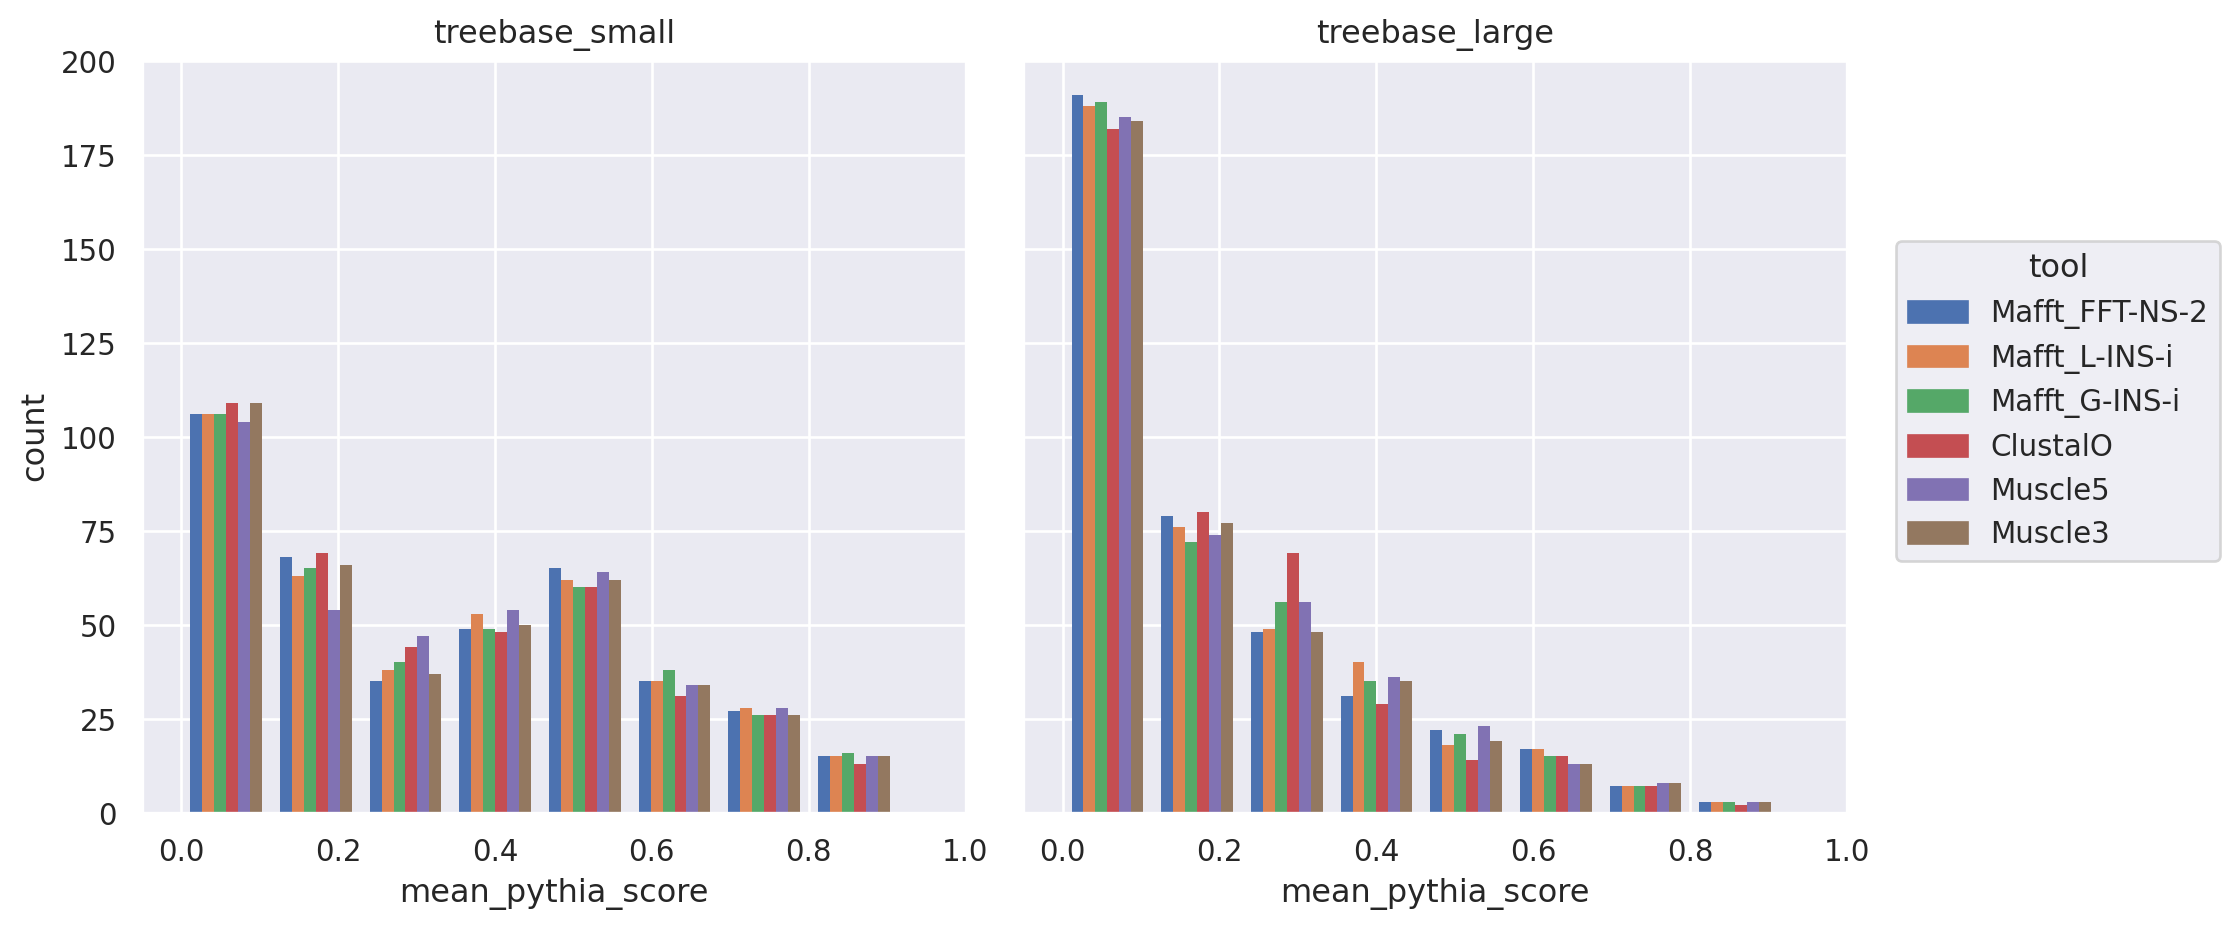

In [15]:
# Plot pythia distribution for different aligners
utils.plots.hist_facet_plot(
    aligned_features[aligned_features.tool != "all"],
    feature="mean_" + FE.PYTHIA_SCORE,
    color="tool",
    facet="benchmark",
)

In [ ]:
import sklearn.ensemble
import sklearn.linear_model
import sklearn.svm
from sklearn.model_selection import train_test_split
import sklearn.metrics

y = aligned_features.sort_values("dataset", ignore_index=True)
y = y.loc[y.tool == "all", "mean_" + FE.HOMOLOGY_POS_DIST]

X = unaligned_features.sort_values("dataset").select_dtypes(exclude="object")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)
rf = sklearn.ensemble.RandomForestRegressor().fit(X_train, y_train)
y_pred = rf.predict(X_test)
eps = 1e-4
print("RMSE: ", 1 / len(y_pred) * np.sqrt(np.linalg.norm(y_test - y_pred)))
print(
    "MAPE: ", sklearn.metrics.mean_absolute_percentage_error(y_test + eps, y_pred + eps)
)
print(y_pred[:10].round(2))
print(list(y_test[:10].round(2)))

eval_df = pd.DataFrame(
    zip(unaligned_features.columns, rf.feature_importances_),
    columns=["feature", "importance"],
)
eval_df = eval_df.sort_values("importance", ascending=False)
eval_df.head()

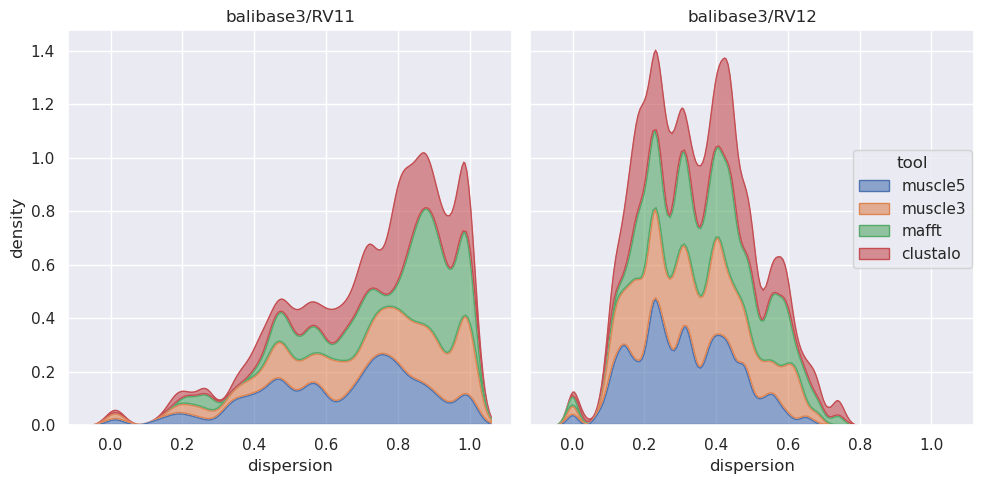

In [ ]:
# import seaborn.objects as so
# import utils.plots as plots

# plot_df = pd.concat((reference_features, aligned_features), axis=0, ignore_index=True)


# out_dir = RESULT_DIR / "plots" / "exploration"
# p = plots.kde_facet_plot(
#     reference_features, x="dispersion", color="tool", facet="benchmark", out_dir=out_dir
# )
# p.show()

Text(0.5, 1.0, 'Reference dispersion (pairwise) against ensemble dispersion. ')

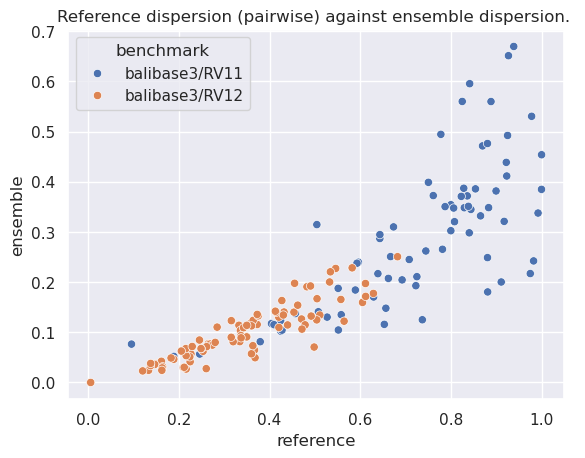

In [ ]:
# from sklearn.linear_model import HuberRegressor, LinearRegression, RANSACRegressor

# # Plot "all" for reference vs. ensemble
# id_cols = ["benchmark", "dataset", "method"]
# grouping_cols = (
#     reference_features.select_dtypes(include="number").columns.to_list() + id_cols
# )
# dispersion_all_ref = (
#     reference_features[grouping_cols]
#     .groupby(id_cols)
#     .mean()
#     .reset_index()[id_cols + ["dispersion"]]
# )
# dispersion_all_ens = (
#     aligned_features[grouping_cols]
#     .groupby(id_cols)
#     .mean()
#     .reset_index()[id_cols + ["dispersion"]]
# )

# dispersion_df = pd.concat(
#     (dispersion_all_ref, dispersion_all_ens), axis=0, ignore_index=True
# )
# dispersion_df = dispersion_df.pivot(
#     index=["benchmark", "dataset"], columns="method", values="dispersion"
# )

# sns.scatterplot(dispersion_df, x="reference", y="ensemble", hue="benchmark")
# plt.title("Reference dispersion (pairwise) against ensemble dispersion. ")